## Notebook for testing and developing Unconditional Diffusion models


### Installing Dependencies

In [1]:
# Uncomment the following line to install the required packages
# %pip install -q diffusers
# %pip install python-dotenv
# %pip install accelerate

### Config

In [2]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # the generated image resolution
    train_batch_size = 12
    eval_batch_size = 12  # how many images to sample during evaluation
    num_epochs = 10
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmup_steps = 500
    save_image_epochs = 10
    save_model_epochs = 30
    num_train_timesteps = 1000
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision
    output_dir = 'unconditional_kneeOA'  
    overwrite_output_dir = True  # overwrite the old model when re-running the notebook
    seed = 0

config = TrainingConfig()

### Load the dataset
Kaggle dataset available at https://www.kaggle.com/datasets/shashwatwork/knee-osteoarthritis-dataset-with-severity was used for the dataloader.  
The DATASET_HOME environment variable was set to the path of the dataset.  
The dataset was downloaded and unzipped in the DATASET_HOME directory.  

Dataset Structure:

DATASET_HOME/  
├── train/  
│   ├── 0/  
│   │   ├── image1L.png  
│   │   ├── image1R.png  
│   │   ├── image2L.png  
│   │   └── ...  
│   ├── 1/  
│   │   ├── image1L.png  
│   │   ├── image1R.png  
│   │   ├── image2L.png  
│   │   └── ...  
│   └── ...  
├── val/  
└── test/  






Training samples: 5778
Validation samples: 826
Test samples: 1656
Input shape: torch.Size([12, 1, 128, 128])
Labels: tensor([3, 0, 1, 3, 2, 2, 1, 0, 1, 3, 2, 2])


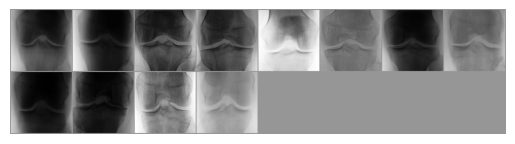

In [3]:
import os
from PIL import Image
import torchvision
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from torchvision import transforms

# Load environment variables
load_dotenv()
dataset_path = os.getenv('DATASET_HOME')

class KneeDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = os.path.join(root_dir, split)
        self.transform = transform
        self.image_paths = []
        self.labels = []
        
        # Iterate through severity folders (0-4)
        for severity in range(5):
            severity_path = os.path.join(self.root_dir, str(severity))
            if not os.path.exists(severity_path):
                continue
                
            # Get all images in the severity folder
            for img_name in os.listdir(severity_path):
                if img_name.endswith(('.png')):
                    self.image_paths.append(os.path.join(severity_path, img_name))
                    self.labels.append(severity)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')  # Convert to grayscale
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

# Create datasets for train, validation and test
train_dataset = KneeDataset(dataset_path, split='train', transform=preprocess)
val_dataset = KneeDataset(dataset_path, split='val', transform=preprocess)
test_dataset = KneeDataset(dataset_path, split='test', transform=preprocess)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=config.train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config.eval_batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Visualize a batch
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")
plt.axis('off')
plt.show()


### Define the model

In [4]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=1,  # the number of input channels, 1 for grayscale images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

### Define the noise scheduler


In [5]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=config.num_train_timesteps)

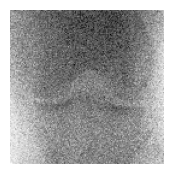

In [6]:
import torch
from PIL import Image

sample_image = train_dataset[0][0].unsqueeze(0) # type: ignore
noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps) # type: ignore

fig = plt.figure(figsize=(2, 2))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(noisy_image.squeeze().cpu().numpy(), cmap="Greys")
plt.axis('off')
plt.show()


### Set up Training Loop

In [7]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate)

In [9]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * config.num_epochs),
)

In [10]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [11]:
from accelerate import Accelerator

from tqdm.auto import tqdm
from pathlib import Path
import os

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        os.makedirs(config.output_dir, exist_ok=True)
    accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, (images, labels) in enumerate(train_dataloader):
            clean_images = images
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                pipeline.save_pretrained(config.output_dir) 

In [12]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=2)

Launching training on 2 GPUs.


/home/khizar/anaconda3/envs/mlflow/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/home/khizar/anaconda3/envs/mlflow/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
/home/khizar/anaconda3/envs/mlflow/lib/python3.10/site-packages/torch/autograd/graph.py:823: UserWarning: Grad

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/241 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
import accelerate
accelerate.__version__

'1.3.0'